In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
import json
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import mplhep as hep
hep.style.use("CMS")


df = pd.read_parquet(r'C:\Users\drpla\Desktop\ICL-PHYSICS-YEAR-4\Masters Project\Data\New folder\merged_nominal.parquet')

with open(r'C:\Users\drpla\Desktop\ICL-PHYSICS-YEAR-4\Masters Project\Data\New folder\summary.json', "r") as f:
  proc_dict = json.load(f)["sample_id_map"]
  
  
sig = df[df.process_id == proc_dict["GluGluToRadionToHHTo2G2Tau_M-300"]] # just one signal process, mass of X is 1000 GeV
sig['Classification']=np.ones(sig['Diphoton_mass'].size)
#bkg = df[df.process_id == proc_dict["DiPhoton"]] # just one of the background processes

C:\Users\drpla\AppData\Local\Temp\ipykernel_21848\476142825.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sig['Classification']=np.ones(sig['Diphoton_mass'].size)


In [50]:
"""Concatenating the background data"""
background_list=['Data','DiPhoton', 'TTGG', 'TTGamma',#list of each bkgs for concatenation
 'TTJets',
 'VBFH_M125',
 'VH_M125',
 'WGamma',
 'ZGamma',
 'ggH_M125', 
 'ttH_M125',
 'GJets']

listforconc=[]
for i in background_list:                               #creating a concatenated list of bkg
    bkgg = df[df.process_id == proc_dict[i]]
    listforconc.append(bkgg)
    
background = pd.concat(listforconc)
background['Classification']=np.zeros(background['Diphoton_mass'].size)

In [51]:
MinusNineBinning=['ditau_met_dPhi',
                  'ditau_deta',
                  'ditau_dR',
                  'ditau_dphi',
                  'ditau_pt',
                  'Diphoton_ditau_dphi',
                  'dilep_leadpho_mass',
                  'reco_MX_mgg',
                  'Diphoton_ditau_deta',
                  'Diphoton_sublead_lepton_deta',
                  'Diphoton_sublead_lepton_dR',
                  'LeadPhoton_ditau_dR',
                  'ditau_mass']


In [24]:
print(background['weight_central'].sum(),sig['weight_central'].sum())

"rescale all of signal up to the number of background weighting"

scale=background['weight_central'].sum()/sig['weight_central'].sum()

sig['weight_central'] = sig['weight_central']*scale

print(sig['weight_central'].sum())

90225.55 25.34767
90225.55


C:\Users\drpla\AppData\Local\Temp\ipykernel_21848\978373548.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sig['weight_central'] = sig['weight_central']*scale


In [52]:
sig['weight_central']

1314751    0.000302
1314752    0.000316
1314753    0.000364
1314754    0.000329
1314755    0.000401
             ...   
1381723    0.000527
1381724    0.000519
1381725    0.000507
1381726    0.000492
1381727    0.000387
Name: weight_central, Length: 66645, dtype: float32

In [53]:
"""Concatenating Signal and Background"""
"""Choosing Best Features given the M=1000 AUC scores"""
FullSignalBackground=pd.concat([sig,background])

df_TopFeatures=pd.DataFrame()

TopFeatures=['reco_MX_mgg','Diphoton_pt_mgg','LeadPhoton_pt_mgg','ditau_pt','Diphoton_dPhi','dilep_leadpho_mass','lead_lepton_pt','MET_pt','ditau_dR','SubleadPhoton_pt_mgg','Diphoton_lead_lepton_deta','ditau_met_dPhi','ditau_deta','Diphoton_sublead_lepton_deta','Diphoton_ditau_deta','ditau_mass','weight_central','Classification']
#TopFeatures=['reco_MX_mgg','Diphoton_pt_mgg','LeadPhoton_pt_mgg','ditau_pt','Diphoton_dPhi','dilep_leadpho_mass','lead_lepton_pt','MET_pt','ditau_dR','SubleadPhoton_pt_mgg','weight_central','Classification']


for feature in TopFeatures:
    df_TopFeatures[feature]=FullSignalBackground[feature]
    
#for columns in MinusNineBinning:
 #   if columns in df_TopFeatures.columns:
  #      df_TopFeatures[columns] = df_TopFeatures[columns].mask(df_TopFeatures[columns] < -8, 0)
   
for columns in df_TopFeatures.columns:
    if columns in MinusNineBinning:
        print(columns)
        df_TopFeatures = df_TopFeatures.loc[(df_TopFeatures[columns] > -8)]
#        signal_subset = signal_subset.loc[(signal_subset['ditau_pt'] >= 0)]


reco_MX_mgg
ditau_pt
dilep_leadpho_mass
ditau_dR
ditau_met_dPhi
ditau_deta
Diphoton_sublead_lepton_deta
Diphoton_ditau_deta
ditau_mass


In [54]:
df_TopFeatures

,reco_MX_mgg,Diphoton_pt_mgg,LeadPhoton_pt_mgg,ditau_pt,Diphoton_dPhi,dilep_leadpho_mass,lead_lepton_pt,MET_pt,ditau_dR,SubleadPhoton_pt_mgg,Diphoton_lead_lepton_deta,ditau_met_dPhi,ditau_deta,Diphoton_sublead_lepton_deta,Diphoton_ditau_deta,ditau_mass,weight_central,Classification
1314751,1.724472,0.551937,0.521988,70.565506,1.805603,172.635971,50.522717,27.473833,1.971192,0.338033,-0.823359,1.579931,0.031067,-0.792292,-0.759005,94.308601,0.000302,1.0
1314753,1.854888,0.840922,0.551521,26.514931,-1.324463,91.822800,36.084164,71.722595,3.267236,0.514404,-0.104924,0.153474,-1.053726,-1.158650,-1.986899,110.728401,0.000364,1.0
1314754,1.965210,1.087142,0.671400,15.814786,1.139099,155.468185,48.846729,15.152800,3.105144,0.619086,0.006167,-1.302164,0.920532,0.926699,2.518824,139.282089,0.000329,1.0
1314756,2.015380,0.731508,0.893332,103.449036,2.262922,148.650681,33.852161,81.881859,2.439430,0.320946,-0.122603,-0.247738,-1.096924,-1.219527,-0.169432,96.281258,0.000334,1.0
1314757,1.770245,0.101058,0.552153,111.229942,3.104248,154.065140,62.064354,59.940231,2.153277,0.452835,-2.922050,-0.046344,-0.931458,-3.853508,-2.922484,116.100319,0.000300,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391609,1.437515,0.449918,0.466802,65.936485,1.915650,95.951546,25.578125,45.783176,1.982261,0.254887,-0.571847,-0.214203,1.741211,1.169364,-0.361142,73.061668,0.002675,0.0
391634,1.170662,1.546191,1.416875,50.710842,1.401001,61.147488,25.149065,78.078995,1.055148,0.424275,0.971381,1.955218,-0.917725,0.053656,0.367382,28.362379,0.004409,0.0
391675,1.238011,0.374783,0.513667,49.091106,-2.327698,199.662491,23.732645,52.639599,1.789111,0.320778,1.191535,-1.881135,1.221741,2.413276,2.097417,53.039040,0.002605,0.0
391683,1.897455,0.409412,0.539126,35.167339,-2.354980,96.012314,23.066645,12.246641,1.867417,0.528867,1.040870,-0.228944,-0.394287,0.646583,1.284298,36.073116,0.004100,0.0


In [55]:

features = df_TopFeatures.drop(columns=['Classification'])  # Extracting features
labels = df_TopFeatures['Classification']  # Extracting labels

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=(1/3), random_state=42)
test_weights=pd.DataFrame()
train_weights=pd.DataFrame()
train_weights['weight_central']=train_features['weight_central']
test_weights['weight_central']=test_features['weight_central']

train_features=train_features.drop(columns=['weight_central'])
test_features=test_features.drop(columns=['weight_central'])

train_features_tensor = torch.tensor(train_features.values, dtype=torch.float32)
train_weights_tensor = torch.tensor(train_weights.values,dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels.values,dtype=torch.float32)


In [58]:
train_labels==1

1314980     True
161542     False
105289     False
99068      False
59721      False
           ...  
104236     False
69218      False
129991     False
161923     False
108597     False
Name: Classification, Length: 103737, dtype: bool

In [59]:
class SimpleNN(nn.Module):
#     def __init__(self,input,hidden,output):
#         super(SimpleNN, self).__init__()
#         self.fc1 = nn.Linear(input,hidden)  # Input layer to hidden layer
#         self.relu1 = nn.ReLU()  # Activation function
#         self.fc2 = nn.Linear(hidden, output)  # Hidden layer to output layer
        
#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.relu1(x)
#         x = self.fc2(x)
#         x = torch.sigmoid(x)
#         return x
    
    
    def __init__(self):
        super(SimpleNN,self).__init__()
        self.hidden1 = nn.Linear(16, 20)
        self.act1 = nn.ReLU()
        self.hidden2 = nn.Linear(20, 8)
        self.act2 = nn.ReLU()
        self.output = nn.Linear(8, 1)
        self.act_output = nn.Sigmoid()

    def forward(self, x):
        x = self.hidden1(x)
        x = self.act1(x)
        x = self.hidden2(x)
        x = self.act2(x)
        x = self.output(x)
        x = self.act_output(x)

        return x


    def weightedBCELoss(self, input, target, weight):
      x, y, w = input, target, weight
      log = lambda x: torch.log(x*(1-1e-8) + 1e-8)
      #return torch.mean(-w * (y*log(x) + (1-y)*log(1-x)))
      return -w * (y*log(x) + (1-y)*log(1-x))
    
    def batch_weightedBCELoss(self, input, target, weight, batch_size):
#batch_weightedBCELoss(self, train, train_labels_tensor, train_weights_tensor, batch_size)
        self.batch_size=batch_size

        target=target.unsqueeze(1)
        
        
       # train=model.forward(input)

        total_batch_err=torch.empty(0,1)
        output_length=input.shape[0]
        batch_remainder=output_length%batch_size

        for i in range(0, output_length//batch_size):
            weights = weight[i*(batch_size):(i+1)*(batch_size), :]
            labels = target[i*(batch_size):(i+1)*(batch_size), :]
            inputs = input[i*(batch_size):(i+1)*(batch_size), :]

            loss=self.weightedBCELoss(inputs, labels, weights)

            total_batch_err=torch.cat((total_batch_err,loss)) 
        #    print(total_batch_err.shape[0])

        if batch_remainder > 0:
            weights = weight[(output_length//batch_size)*batch_size:, :]
            labels = target[(output_length//batch_size)*batch_size:, :]
            inputs = input[(output_length//batch_size)*batch_size:, :]

            loss=self.weightedBCELoss(inputs, labels, weights)

            #weights = train_weights_tensor[(train_weights_tensor.shape[0]//batch_size)*batch_size:, :]
            total_batch_err=torch.cat((total_batch_err,loss))
        #    print(total_batch_err.shape[0])
            
        return torch.mean(total_batch_err)


In [60]:
model = SimpleNN()

In [ ]:
#trained=model.forward(train_features_tensor)

In [ ]:
#model.batch_weightedBCELoss(trained,train_labels_tensor,train_weights_tensor,1024)

For Epoch 1: Loss = 0.10599588602781296
For Epoch 2: Loss = 0.09742069989442825
For Epoch 3: Loss = 0.08931111544370651
For Epoch 4: Loss = 0.08161082863807678
For Epoch 5: Loss = 0.07417886704206467
For Epoch 6: Loss = 0.0672256126999855
For Epoch 7: Loss = 0.06052270159125328
For Epoch 8: Loss = 0.05414891615509987
For Epoch 9: Loss = 0.048383310437202454
For Epoch 10: Loss = 0.043064095079898834
For Epoch 11: Loss = 0.03812972456216812
For Epoch 12: Loss = 0.033371977508068085
For Epoch 13: Loss = 0.02896365337073803
For Epoch 14: Loss = 0.025167984887957573
For Epoch 15: Loss = 0.021746888756752014
For Epoch 16: Loss = 0.01869504339993
For Epoch 17: Loss = 0.015958750620484352
For Epoch 18: Loss = 0.01358222495764494
For Epoch 19: Loss = 0.011542520485818386
For Epoch 20: Loss = 0.009811664931476116
For Epoch 21: Loss = 0.008353576064109802
For Epoch 22: Loss = 0.007138860411942005
For Epoch 23: Loss = 0.006140085402876139
For Epoch 24: Loss = 0.0053219664841890335
For Epoch 25: Lo

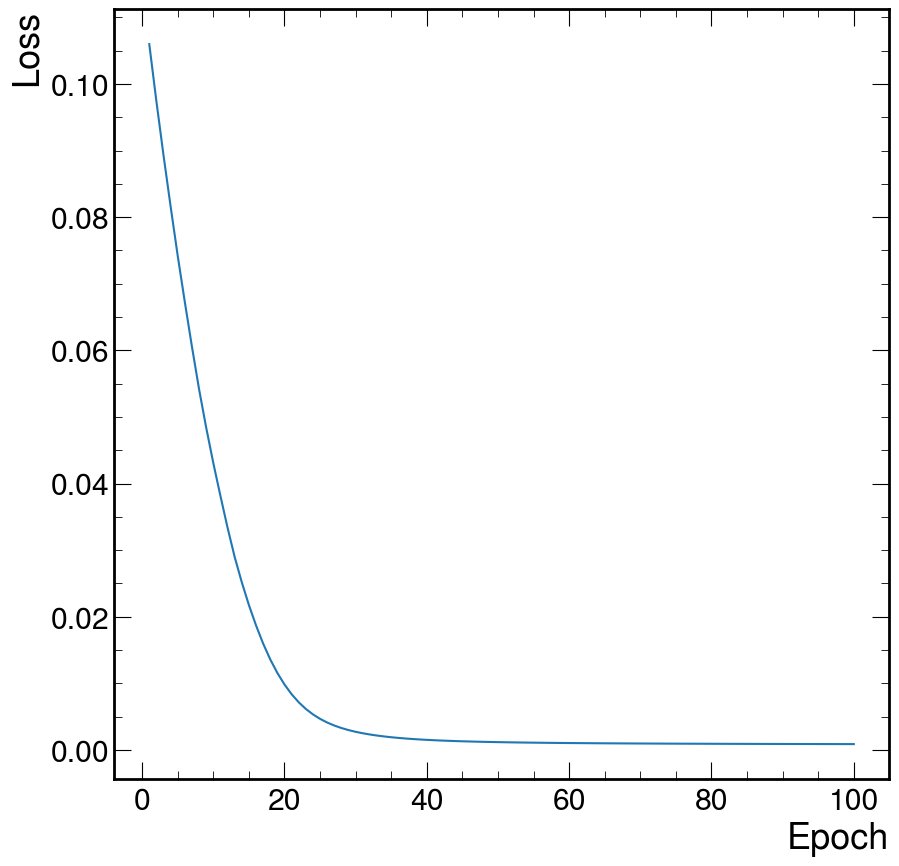

In [61]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
lossdata=[]
epochs=100
epochlist=[]
for i in range(0,100):
    epochlist.append(i+1)
for i in range(0,epochs):
    trained=model.forward(train_features_tensor)
    loss=model.batch_weightedBCELoss(trained,train_labels_tensor,train_weights_tensor,1024)
    lossdata.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f'For Epoch {i+1}: Loss = {loss}')
figure=plt.figure()
plt.plot(epochlist,lossdata)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()    

In [ ]:
figure=plt.figure()
plt.plot(epochlist,lossdata)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()    

In [ ]:
lossdata=[]
for i in range(0,10):
    trained=model.forward(train_features_tensor)
    loss=model.batch_weightedBCELoss(trained,train_labels_tensor,train_weights_tensor,1024)
    lossdata.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    plt.hist(trained.squeeze().tolist(),bins=80,label='predicted',histtype="step")
    #plt.hist(train_labels_tensor.tolist(),bins=80,label='output',histtype="step")
    plt.show()
print(lossdata)

In [ ]:
for i in range(0,100):
    epochlist.append(i+1)
figure=plt.figure()
plt.plot(epochlist,lossdata)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()    

(array([ 1405.,   282.,   232.,   166.,   156.,   123.,   110.,   144.,
          116.,   132.,    98.,   101.,    97.,    95.,    96.,   117.,
          115.,    99.,   103.,    90.,    96.,   100.,   109.,   104.,
          102.,   102.,   124.,   122.,   121.,   125.,   156.,   157.,
          142.,   164.,   178.,   182.,   183.,   209.,   195.,   217.,
          228.,   269.,   238.,   261.,   295.,   300.,   381.,   359.,
          348.,   389.,   437.,   476.,   496.,   543.,   595.,   660.,
          710.,   740.,   889.,   918.,  1065.,  1126.,  1258.,  1365.,
         1442.,  1739.,  1937.,  2147.,  2383.,  2812.,  3100.,  3619.,
         4118.,  4557.,  5110.,  5598.,  6200.,  7263.,  9353., 21248.]),
 array([0.    , 0.0125, 0.025 , 0.0375, 0.05  , 0.0625, 0.075 , 0.0875,
        0.1   , 0.1125, 0.125 , 0.1375, 0.15  , 0.1625, 0.175 , 0.1875,
        0.2   , 0.2125, 0.225 , 0.2375, 0.25  , 0.2625, 0.275 , 0.2875,
        0.3   , 0.3125, 0.325 , 0.3375, 0.35  , 0.3625, 0.375 

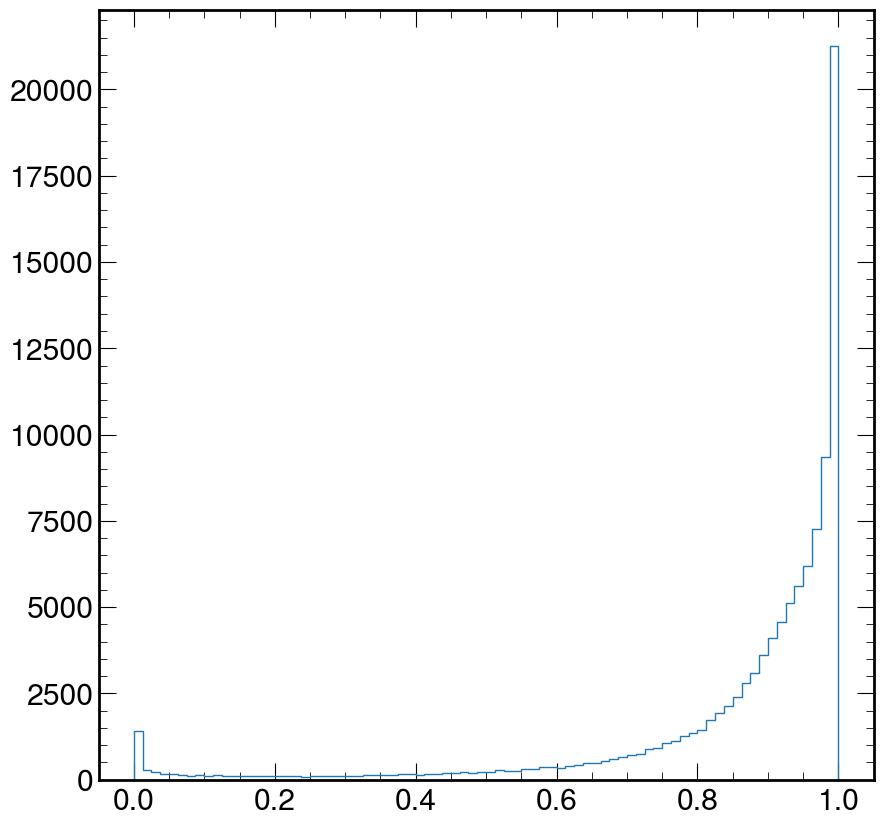

In [38]:
    plt.hist(trained.squeeze().tolist(),bins=80,label='predicted',histtype="step")
plt.show()


In [ ]:
data = trained.squeeze().tolist()  # Replace with your dataset

chunk_size = 1000  # Define the chunk size

# Process data in chunks
for i in range(0, len(data), chunk_size):
    chunk = data[i:i+chunk_size]  # Get a chunk of data
   # print('Processed Chunk', len(chunk))  # Process the chunk
HELPPPPPP


In [ ]:
error = weightedBCELoss(trained, train_labels_tensor, train_weights_tensor)

In [ ]:
for i in range(0,size/batchsize):
    weights = train_weights_tensor[:1024, :]
    labels = train_labels_tensor.unsqueeze(1)[:1024,:]
    training = trained[:1024,:]

In [ ]:
error = weightedBCELoss(training, labels, weights)
error

In [ ]:
error.shape

In [ ]:
batch_size=1024

train=model.forward(train_features_tensor)

total_batch_err=torch.empty(0,1)
output_length=train_weights_tensor.shape[0]
batch_remainder=output_length%batch_size

for i in range(0, output_length//batch_size):
    weights = train_weights_tensor[i*(batch_size):(i+1)*(batch_size), :]
    labels = train_weights_tensor[i*(batch_size):(i+1)*(batch_size), :]
    inputs = train[i*(batch_size):(i+1)*(batch_size), :]

    loss=weightedBCELoss(inputs, labels, weights)
    
    total_batch_err=torch.cat((total_batch_err,loss)) 
    print(total_batch_err.shape[0])
    
if batch_remainder > 0:
    weights = train_weights_tensor[(output_length//batch_size)*batch_size:, :]
    labels = train_weights_tensor[(output_length//batch_size)*batch_size:, :]
    inputs = train[(output_length//batch_size)*batch_size:, :]

    loss=weightedBCELoss(inputs, labels, weights)
    
    weights = train_weights_tensor[(train_weights_tensor.shape[0]//batch_size)*batch_size:, :]
    total_batch_err=torch.cat((total_batch_err,weights))
    print(total_batch_err.shape[0])

In [ ]:
i=0
weights1 = train_weights_tensor[i*(1024):(i+1)*(1024), :]
i=1
weights2 = train_weights_tensor[i*(1024):(i+1)*(1024), :]

In [ ]:
1195600-1197414


In [ ]:
623536-623616

In [ ]:
for i in range(0, train_weights_tensor.shape[0]//1024):
    print(i)

In [ ]:
607*1024

In [ ]:
train_features_tensor.shape

In [ ]:
623536-621568

In [ ]:
append=torch.empty(0,1)


In [ ]:
append=torch.cat((append,weights1))

In [ ]:
append.shape

In [ ]:
train_features_tensor.shape

In [ ]:
623536-622592


In [ ]:
623536%1024

In [ ]:
total_batch_err.shape

In [ ]:
df_TopFeatures.iloc[(df_TopFeatures['reco_MX_mgg']<-9)]

In [ ]:
df_TopFeatures

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

# Create a figure and axis
fig, ax = plt.subplots()
x_data = np.linspace(0, 2*np.pi, 100)
line, = ax.plot([], [], lw=2)

# Initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# Animation function: this is called sequentially
def animate(i):
    y_data = np.sin(x_data + 0.1 * i)
    line.set_data(x_data, y_data)
    return line,

# Create animation
anim = FuncAnimation(fig, animate, init_func=init, frames=100, interval=50, blit=True)

# Display the animation
plt.show()

In [ ]:
train_features

In [ ]:
df_TopFeatures['reco_MX_mgg']=df_TopFeatures['reco_MX_mgg'] < -8    

In [46]:
train_labels[train_labels==0].sum()

train_labels

1314980    1.0
161542     0.0
105289     0.0
99068      0.0
59721      0.0
          ... 
104236     0.0
69218      0.0
129991     0.0
161923     0.0
108597     0.0
Name: Classification, Length: 103737, dtype: float64

In [48]:
train_labels[train_labels==1].sum()


21967.0